[INFO] loading images...


C:\Users\LIKHI\anaconda3\envs\tf_gpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


[INFO] compiling model...
[INFO] training head...
Train for 127 steps, validate on 1019 samples
Epoch 1/5
127/127 [==============================] - 50s 396ms/step - loss: 0.2792 - accuracy: 0.8800 - val_loss: 0.0444 - val_accuracy: 0.9960
Epoch 2/5
127/127 [==============================] - 46s 366ms/step - loss: 0.0952 - accuracy: 0.9681 - val_loss: 0.0225 - val_accuracy: 0.9940
Epoch 3/5
127/127 [==============================] - 47s 370ms/step - loss: 0.0668 - accuracy: 0.9780 - val_loss: 0.0141 - val_accuracy: 0.9970
Epoch 4/5
127/127 [==============================] - 53s 419ms/step - loss: 0.0481 - accuracy: 0.9844 - val_loss: 0.0162 - val_accuracy: 0.9950
Epoch 5/5
127/127 [==============================] - 54s 424ms/step - loss: 0.0431 - accuracy: 0.9847 - val_loss: 0.0154 - val_accuracy: 0.9960
[INFO] evaluating network...
              precision    recall  f1-score   support

  JPEGImages       0.99      1.00      1.00       635
without_mask       1.00      0.99      0.99   

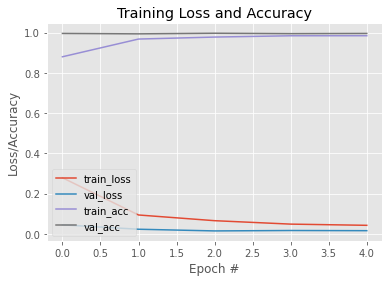

In [9]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

DIRECTORY = r"C:\Users\LIKHI\Documents\Python Scripts\Face-Mask-Detection-master\dataset"
#CATEGORIES = ["with_mask", "without_mask"]
CATEGORIES = ["JPEGImages","without_mask"]
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector2.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [2]:
import cv2
import numpy as np
from PIL import Image
import os

# Path for face image database
path = 'C:\\Users\\LIKHI\\Documents\\Python Scripts\\dataset'

recognizer = cv2.face.LBPHFaceRecognizer_create()
#recognizer = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier('C:\\Users\\LIKHI\\Documents\\Python Scripts\\Cascade\\haarcascade_frontalface_default.xml');

# function to get the images and label data
def getImagesAndLabels(path):
    imagePaths = [os.path.join(path,f) for f in os.listdir(path)]     
    faceSamples=[]
    ids = []
    for imagePath in imagePaths:
        PIL_img = Image.open(imagePath).convert('L') # convert it to grayscale
        img_numpy = np.array(PIL_img,'uint8')
        id = int(os.path.split(imagePath)[-1].split(".")[1])
        faces = detector.detectMultiScale(img_numpy)
        for (x,y,w,h) in faces:
            faceSamples.append(img_numpy[y:y+h,x:x+w])
            ids.append(id)
    return faceSamples,ids

print ("\n [INFO] Training faces. It will take a few seconds. Wait ...")
faces,ids = getImagesAndLabels(path)
recognizer.train(faces, np.array(ids))

# Save the model into trainer/trainer.yml
recognizer.write('C:\\Users\\LIKHI\\Documents\\Python Scripts\\trainer\\trainer.yml') # recognizer.save() worked on Mac, but not on Pi

# Print the numer of faces trained and end program
print("\n [INFO] {0} faces trained. Exiting Program".format(len(np.unique(ids))))


 [INFO] Training faces. It will take a few seconds. Wait ...

 [INFO] 4 faces trained. Exiting Program


In [1]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

 

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

 

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)

 

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

 

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

 

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

 

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

 

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

 

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

 

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

 

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

 

# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

 

# load the face mask detector model from disk
maskNet = load_model("mask_detector2.model")

 

# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

 

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame1 = vs.read()
    frame = imutils.resize(frame, width=1000)

 

    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

 

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

 

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

 

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

 

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

 

        #import uuid
        #face_id ="1"
        #print(label)
        #if label.split(":")[0]=="No Mask":
            #img = Image.fromarray(frame, 'RGB')
            #im = img.crop((startX, startY, endX, endY))
            ##print(label)
            #im.save(face_id+'.png')

 

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

 

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

 

 #do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 2

(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200

In [16]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

 

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

 

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    #print(detections)

 

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

 

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

 

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.9:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

 

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

 

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

 

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

 

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

 

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

 

# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

 

# load the face mask detector model from disk
maskNet = load_model("mask_detector_1.model")

 

# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

 

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame1 = vs.read()
    frame = imutils.resize(frame, width=1200)

 

    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

 

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

 

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

 

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

 

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

 

        import uuid
        face_id ="1"
        #print(label)
        if label.split(":")[0]=="No Mask":
            img = Image.fromarray(frame, 'RGB')
            im = img.crop((startX, startY, endX, endY))
            print(label)
            im.save(face_id+'.png')

 

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

 

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

 

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
[[[ 82  52  28]
  [ 78  50  25]
  [ 73  48  22]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 85  56  31]
  [ 81  54  28]
  [ 76  51  24]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 89  61  35]
  [ 85  58  31]
  [ 79  55  26]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  5  21  12]
  [  7  22  14]
  [  9  24  17]
  ...
  [209 231 210]
  [208 231 210]
  [208 231 210]]

 [[  3  20  11]
  [  5  21  13]
  [  7  22  15]
  ...
  [209 232 212]
  [210 233 212]
  [210 233 213]]

 [[  2  19  10]
  [  3  20  12]
  [  5  21  14]
  ...
  [210 233 213]
  [211 234 214]
  [212 235 215]]]
[[[ 94  53   7]
  [ 87  47   4]
  [ 77  39   0]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 96  56  10]
  [ 90  51   7]
  [ 83  45   4]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 99  60  15]
  [ 96  57  12]
  [ 91  54   8]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  0   6   0]
  [ 

[[[102  51  25]
  [ 97  47  19]
  [ 90  41  12]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 98  48  21]
  [ 93  44  16]
  [ 88  41  11]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 92  44  16]
  [ 89  42  13]
  [ 85  40   9]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  7   5   5]
  [  5   3   3]
  [  3   1   1]
  ...
  [230 220 201]
  [230 219 200]
  [230 219 200]]

 [[  8   5   5]
  [  6   3   3]
  [  3   1   1]
  ...
  [239 228 210]
  [238 227 209]
  [238 226 208]]

 [[  8   6   6]
  [  6   4   4]
  [  3   1   1]
  ...
  [247 235 217]
  [245 233 215]
  [244 232 214]]]
[[[ 78  44   7]
  [ 84  51  14]
  [ 91  59  23]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 83  47   9]
  [ 88  53  16]
  [ 95  61  25]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 89  51  13]
  [ 94  57  19]
  [100  64  27]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  0   7   0]
  [  0   6   0]
  [  0   4   0]
  ..

[[[108  63  20]
  [101  56  14]
  [ 92  47   6]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[102  58  14]
  [ 97  54  11]
  [ 91  48   6]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 94  52   7]
  [ 92  51   7]
  [ 90  49   6]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  3   0   7]
  [  3   0   7]
  [  3   0   6]
  ...
  [229 223 205]
  [226 220 203]
  [224 217 202]]

 [[  6   3  11]
  [  4   2   9]
  [  1   0   6]
  ...
  [238 230 212]
  [235 227 209]
  [232 224 208]]

 [[  8   5  15]
  [  5   3  11]
  [  0   0   6]
  ...
  [246 236 217]
  [242 232 214]
  [239 229 212]]]
[[[ 98  49   3]
  [ 97  49   4]
  [ 95  48   5]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[100  52   5]
  [ 98  51   6]
  [ 96  50   6]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[102  56   8]
  [100  54   8]
  [ 97  52   8]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  4   0   0]
  [  4   0   0]
  [  3   1   0]
  ..

[[[100  42   0]
  [100  44   1]
  [100  47   3]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[100  45   3]
  [100  47   4]
  [100  49   5]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[100  48   6]
  [100  50   7]
  [101  53   9]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  0   1   0]
  [  0   1   0]
  [  0   1   0]
  ...
  [228 222 209]
  [226 221 208]
  [225 220 208]]

 [[  2   5   2]
  [  2   5   2]
  [  2   4   3]
  ...
  [236 229 216]
  [235 227 216]
  [233 226 215]]

 [[  3   8   4]
  [  3   8   4]
  [  3   7   5]
  ...
  [243 235 222]
  [241 233 221]
  [240 231 221]]]
[[[115  52  16]
  [112  49  14]
  [107  46  12]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[111  50  13]
  [108  49  13]
  [105  46  12]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[106  48  10]
  [105  48  11]
  [103  47  12]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  6   2   1]
  [  6   1   1]
  [  5   0   0]
  ..

[[[100  55  28]
  [101  55  27]
  [102  56  25]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[100  56  28]
  [101  56  26]
  [101  56  24]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[101  58  28]
  [101  57  25]
  [101  56  22]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[  1   0   0]
  [  1   0   0]
  [  0   0   0]
  ...
  [234 224 204]
  [230 220 200]
  [226 216 197]]

 [[  3   2   1]
  [  2   2   0]
  [  1   1   0]
  ...
  [242 232 211]
  [238 227 207]
  [234 224 204]]

 [[  5   4   1]
  [  3   3   1]
  [  1   1   0]
  ...
  [249 238 216]
  [245 234 212]
  [241 230 209]]]
[[[ 84  53  14]
  [ 78  47   8]
  [ 71  39   0]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 86  54  16]
  [ 81  48  10]
  [ 74  41   3]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 [[ 89  56  19]
  [ 84  50  13]
  [ 78  43   6]
  ...
  [255 255 252]
  [255 255 252]
  [255 255 252]]

 ...

 [[ 17   9   0]
  [ 14   7   0]
  [ 11   5   0]
  ..

In [23]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

 

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

 

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)

 

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

 

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

 

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

 

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

 

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

 

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

 

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

 

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

 

# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

 

# load the face mask detector model from disk
maskNet = load_model("mask_detector2.model")

img=Image.open(r'C:\Users\LIKHI\Documents\Python Scripts\Face-Mask-Detection-master\test.jpg')
img = asarray(img)
detect_and_predict_mask(img, faceNet, maskNet)

(1, 1, 200, 7)


([(544, 127, 716, 342)], array([[0.00151998, 0.99848   ]], dtype=float32))

In [32]:
img=Image.open(r'C:\Users\LIKHI\Documents\Python Scripts\Face-Mask-Detection-master\test.jpg')

In [40]:


image = load_img(r'C:\Users\LIKHI\Documents\Python Scripts\Face-Mask-Detection-master\test.jpg', target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)

#data.append(image)
#labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

ValueError: Unknown label type: (array([[[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]], dtype=float32),)

In [2]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

 

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

 

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    #print(detections)

 

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

 

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

 

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.9:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

 

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

 

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

 

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

 

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

 

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

 

# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

 

# load the face mask detector model from disk
maskNet = load_model("mask_detector_1.model")

 

# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

 

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame1 = vs.read()
    frame = imutils.resize(frame, width=1200)

 

    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

 

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

 

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

 

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

 

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

 

        #import uuid
        #face_id ="1"
        #print(label)
        #if label.split(":")[0]=="No Mask":
            #img = Image.fromarray(frame, 'RGB')
            #im = img.crop((startX, startY, endX, endY))
            #print(label)
            #im.save(face_id+'.png')

 

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

 

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

 

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()





[INFO] starting video stream...


In [28]:
maskNet = load_model("mask_detector2.model")

In [29]:
maskNet.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x000001F75B774160>>

In [37]:
maskNet.predict(image)

ValueError: Error when checking input: expected input_4 to have 4 dimensions, but got array with shape (224, 224, 3)